In [1]:
# импорт необходимых библиотек
import os
import re
import pandas as pd
import numpy as np
from typing import List
from docx import Document
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# путь к директории с файлами
directory = "data/train_data/"

In [3]:
# списки файлов HMI и SSTS
hmi_files = []
ssts_files = []

# получение patch файлов по контексту
for root, dirs, files in os.walk(directory, topdown = False):
   for name in files:
      # файлы директории HMI
      if "HMI" in root:
         hmi_files.append(os.path.join(root, name))
      # файлы директории SSTS
      if "SSTS" in root:
         ssts_files.append(os.path.join(root, name))

In [4]:
# проверка данных
len(hmi_files), len(ssts_files)

(12, 11)

In [5]:
def open_docx_file(pacth: str, file_folder: str)-> List[str]:
    """функция извлечения текста из файлов с расширением .docx

    Args:
        pacth (str): путь к файлу

    Returns:
        List[str]: [наименование функции, текс файла]
    """

    document = Document(pacth)
    paragraphs = [p.text.strip().replace("\xa0", " ") for p in document.paragraphs if len(p.text) != 0]

    if file_folder == "HMI":
        return [paragraphs[0].split("]")[-1].strip(), " ".join(paragraphs[1:])]
    if file_folder == "SSTS":
        return [paragraphs[0].strip(), " ".join(paragraphs[1:])]

In [6]:
def findall_numbers(text: str) -> int:
    """функция извлечения номера файла из patch файла

    Args:
        text (str): путь к файлу

    Returns:
        int: номер файла
    """
    numbers = re.findall(r'\b\d+\b', text)
    return numbers[0]

In [7]:
# обработка файлов HMI 
hmi_text = []
for hmi_file in hmi_files:
    name, text = open_docx_file(hmi_file, "HMI")
    number = findall_numbers(hmi_file)
    hmi_text.append([number, name, text])

In [8]:
# обработка файлов SSTS 
ssts_text = []
for ssts_file in ssts_files:
    name, text = open_docx_file(ssts_file, "SSTS")
    number = findall_numbers(ssts_file)
    ssts_text.append([number, name, text])

In [9]:
# преобразование в DataFrame
hmi_df = pd.DataFrame(hmi_text, columns=["Number", "Name", "Text"])
hmi_df.head() 

,Number,Name,Text
0,31523,Adding Internet Radio to Favorites List,Description: Use Case: Adding Internet Radio t...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo..."
4,30371,ERA Self-diagnosis,Actors: ERA-Glonass system Description: ERA se...


In [10]:
# удаление не релевантного текста
hmi_df["Text"] = hmi_df["Text"].apply(lambda x: " ".join(x.split()[1:]) if "Description" in x else x)

In [11]:
# преобразование в DataFrame
ssts_df = pd.DataFrame(ssts_text, columns=["Number", "Name", "Text"])
ssts_df.head()

,Number,Name,Text
0,26771,Turn on and off hotspot,Functional Description Users can choose to tur...
1,8692,Manual dialing E-CALL,Functional Description The user presses the SO...
2,25957,Mute or pause function,Functional Description When playing online rad...
3,11467,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...
4,26161,Automatic search,Functional Description Support for searching f...


In [12]:
# удаление не релевантного текста
ssts_df["Text"] = ssts_df["Text"].apply(lambda x: " ".join(x.split()[2:]) if "Functional Description" in x else x)

In [13]:
# объединение данных в файл
train_df = hmi_df.merge(ssts_df, on="Number", how="left", suffixes=["_uc", "_ssts"])
train_df.head()

,Number,Name_uc,Text_uc,Name_ssts,Text_ssts
0,31523,Adding Internet Radio to Favorites List,Use Case: Adding Internet Radio to Favorites L...,Favorite Song operation,Users can set local music as favorites and vie...
1,8800,Receiving Call Notifications,Preconditions Entertainment system is ready. i...,Receiving Call Notifications,"When a mobile phone calls, SWP pops up a Bluet..."
2,11467,Revoke access to the vehicle from a driver or ...,Goal: Enable the Owner to quickly revoke acces...,Users can remotely control the DK deletion thr...,Enabling conditions (a & b): There is at least...
3,28561,Setting Hotspot name & password,"Use-Case Title: ""Setting Hotspot name & passwo...",hotspot settings,Users can modify the name and password of the ...
4,30371,ERA Self-diagnosis,ERA-Glonass system Description: ERA self-diagn...,ERA Self-diagnosis,Self-diagnosis after ERA is started (in ERA st...


In [14]:
# размерность данных
train_df.shape

(12, 5)

In [15]:
# наличие пропусков
train_df.isna().sum()

Number       0
Name_uc      0
Text_uc      0
Name_ssts    1
Text_ssts    1
dtype: int64

In [16]:
# заполнение пропусков
train_df = train_df.fillna("-")

In [17]:
# запись в файл
train_df.to_csv("data/train_df.csv", index=False)

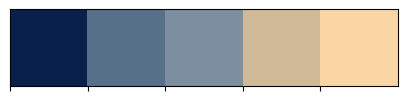

In [18]:
# задание палитры цветов
colors = ["#09214a", "#567189", "#7B8FA1", "#CFB997", "#FAD6A5"]
sns.palplot(sns.color_palette(colors))

In [19]:
# загрузка файла с отчетом
gt = pd.read_excel('data/train_data/train_data_markup.xlsx', keep_default_na=False)
gt.head()

,Number,Name,Differences,Description,Complience Level
0,8800,Receiving Call Notifications,SSTS misses the following content:\n The outpu...,HMX description:\nThe driver can accept or rej...,LC
1,31523,Adding Internet Radio to Favorites List,UC misses the following content:\nUsers can se...,Users can add or remove songs from favorites a...,LC
2,25957,Mute/unmute the FM Radio playback,There is no soft button icon and description i...,The user clicks on the radio and clicks on the...,PC
3,26160,Filtering the internet radio stations,ssts hasn't info about this,-,NA
4,11467,Revoke access to the vehicle from a driver or ...,-,The driver opens the ATOM application on his i...,FC


In [20]:
# проверка на пропуски
gt.isna().sum()

Number              0
Name                0
Differences         0
Description         0
Complience Level    0
dtype: int64

In [21]:
# подсчет количества оценок
cl_count = gt["Complience Level"].value_counts()
cl_count = cl_count[["FC", "LC", "PC", "NC", "NA"]]
cl_count

Complience Level
FC    1
LC    7
PC    1
NC    2
NA    1
Name: count, dtype: int64

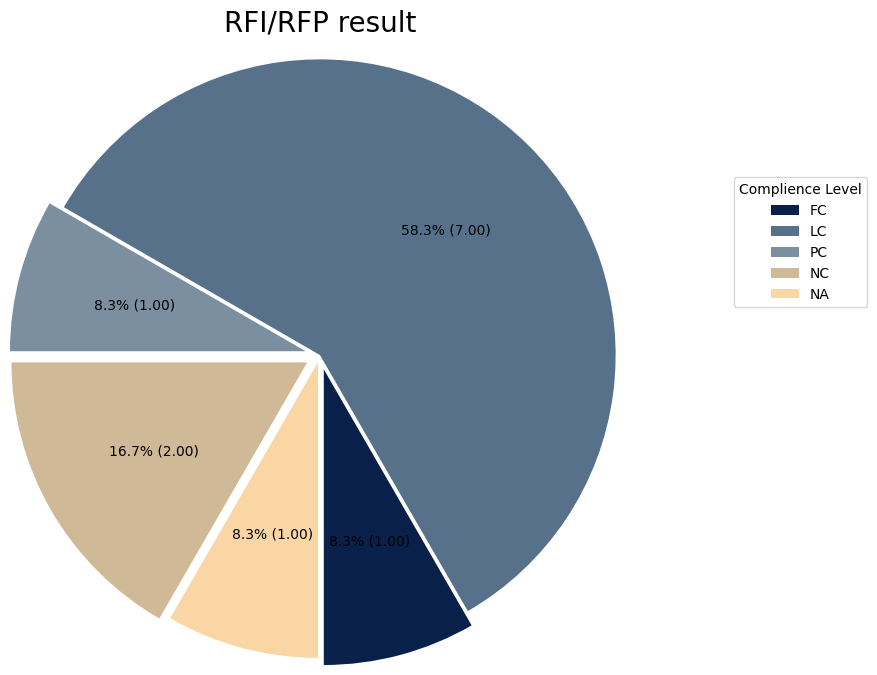

In [23]:
# визуализация соотношения оценок
def func(pct, allvals):
    absolute = float(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:.2f})".format(pct, absolute)

plt.pie(cl_count , colors=colors, \
        autopct=lambda pct: func(pct, cl_count), radius=2, startangle = 270, explode = [0.1, 0, 0.1, 0.1, 0.05])
plt.title("RFI/RFP result", size = 20, pad=100)
plt.legend(labels=cl_count.index, title ="Complience Level", loc="upper right", bbox_to_anchor =(1.5, 0, 0.5, 1))
plt.show()